# PART III
## Kernel perceptron

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from helpers import *
from collections import Counter
from itertools import combinations

np.random.seed(123)  # give a fixed seed for reproducability
from sklearn.model_selection import train_test_split

In [2]:
#loading data
zipcombo = np.loadtxt('zipcombo.dat')
zipcombo_qater = zipcombo[:len(zipcombo)//1]
training_data = np.loadtxt('dtrain123.dat')
test_data = np.loadtxt('dtest123.dat')
x_data, y_labels = split_into_data_and_labels(zipcombo_qater)

#some training data is continuous, need to make sure everything is either -1 or 1

(257,)


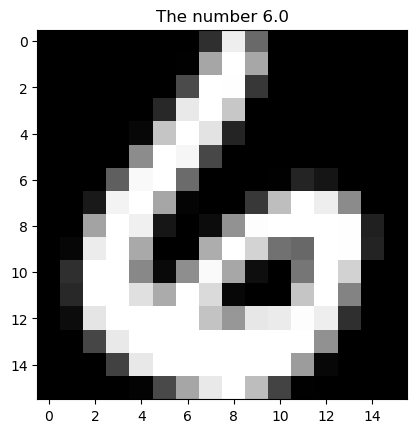

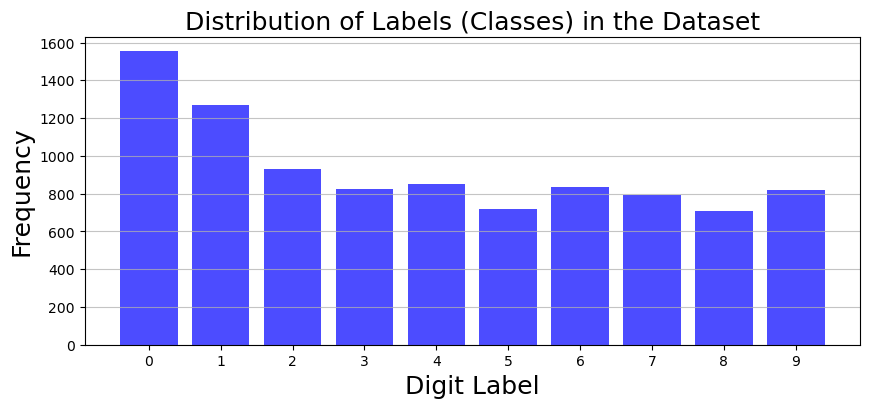

<Figure size 640x480 with 0 Axes>

In [3]:
#plot first char
def plot_char(char):
    data = char[1:].reshape(16, 16)
    plt.imshow(data, cmap='gray')
    plt.title(f"The number {char[0]}")
    plt.show()
print(zipcombo_qater[0].shape)
    
plot_char(zipcombo_qater[0])

def plot_label_distribution(labels):
    plt.figure(figsize=(10, 4),dpi=100)
    plt.hist(labels, bins=np.arange(11) - 0.5, rwidth=0.8, color='blue', alpha=0.7)
    plt.title("Distribution of Labels (Classes) in the Dataset",fontsize=18)
    plt.xlabel("Digit Label",fontsize=18)
    plt.ylabel("Frequency",fontsize=18)
    plt.xticks(range(10))
    plt.grid(axis='y', alpha=0.75)
    plt.show()
    plt.savefig('label_distribution.png')
    
plot_label_distribution(y_labels)

In [4]:
##helper functions(can be extracted into a separate class later)

#polynomial kernel

def polynomial_kernel(p, q, d):
    return (1 + (p@q.T)) ** d

def gaussian_kernel_matrix(X1, X2, sigma):
    # It looks a little weird cause its vectorised
    sq_dists = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-sigma * sq_dists)

#convering the data to -1 and 1
def mysign(data):
    return np.where(data <= 0.0, -1.0, 1.0)

def calculate_confusion_matrix(y_true, y_pred):
    classes = np.unique(y_true)
    matrix = np.zeros((len(classes), len(classes)))

    for true_class in classes:
        for pred_class in classes:
            if true_class != pred_class:  # Exclude diagonal elements
                matrix[true_class, pred_class] = np.sum((y_true == true_class) & (y_pred == pred_class)) / np.sum(y_true == true_class)

    return matrix

def calculate_confusion_matrix_std(confusion_matrices):
    return np.std(confusion_matrices, axis=0)

def plot_test_error(values, mean_test_errors_1vs1, optimizable_param_name, kernel_name):
    plt.figure(figsize=(10, 5), dpi=100)
    plt.plot(values, mean_test_errors_1vs1*100, label='Test Error', marker='o', color='red')
    plt.title(f'Mean Test Error Rates vs Kernel {kernel_name} Parameters', fontsize=18)
    plt.xlabel(f'{optimizable_param_name}', fontsize=18)
    plt.ylabel('Error Rate (%)', fontsize=18)
    plt.legend(fontsize=18)
    plt.tight_layout()
    plt.show()

In [5]:
class KernelPerceptron:
    def __init__(self, n_classes, kernel_function, kernel_param):
        self.n_classes = n_classes
        self.kernel_function = kernel_function
        self.kernel_param = kernel_param
        self.alpha = None
        self.train_data = None

    def fit(self, X_train, y_train, return_training_error=True):
        NB_EPOCHS_MAX = 30
        num_samples = X_train.shape[0]
        self.alpha = np.zeros((self.n_classes, num_samples))
        self.train_data = X_train
        K = self.kernel_function(X_train, X_train, self.kernel_param)
        prev_error = float('inf') 
        epoches = 0
        for epoch in range(NB_EPOCHS_MAX):
            total_mistakes = 0
            for i in range(num_samples):
                scores = np.zeros(self.n_classes)

                scores = K[i]@self.alpha.T
                predicted_class = np.argmax(scores)
                true_class = y_train[i]

                if predicted_class != true_class:
                    self.alpha[true_class, i] += 1
                    self.alpha[predicted_class, i] -=1
                    total_mistakes += 1  # Increment the total number of mistakes

            epoches+=1     

            train_error = total_mistakes / num_samples  # Calculate the training error

            # convergence
            if (prev_error - train_error) < 1e-2:
                break
            prev_error = train_error
        if(return_training_error):
            return train_error

    def predict(self, X_test, y_test, return_labels=False):
        # Calculate the scores for all test samples and classes at once
        K = self.kernel_function(X_test, self.train_data, self.kernel_param)
        scores = np.dot(self.alpha, K.T)

        # Predict the class with the highest score for each test sample
        y_pred = np.argmax(scores, axis=0)

        test_error = np.mean(y_test != y_pred)
        if(return_labels):
            return test_error, y_pred
        return test_error

## Q1

In [6]:
N_RUNS = 20
d_range = np.arange(1, 8, dtype=int)  # k = 1...7
#substitute for the real data with 10

#can be extraced from data
n_classes = len(np.unique(y_labels))

def run_experiment_without_cross_val(x_data, y_labels, N_RUNS, params_range, n_classes, kernel_function: callable, Classifier):
    '''
    Runs the experiment with the given kernel function and parameters range n_runs times
    :param x_data: the data
    :param y_labels: the labels
    :param N_RUNS: number of runs
    :param params_range: the range of the parameters
    :param n_classes: number of classes
    :param kernel_function: the kernel function
    :return: mean_train_errors, mean_test_errors, mean_std_train_errors, mean_std_test_errors
    '''
    train_errors = np.zeros((N_RUNS, len(params_range)))
    #train_errors2 = np.zeros((N_RUNS, len(params_range)))
    test_errors = np.zeros((N_RUNS, len(params_range)))

    for i_run in range(N_RUNS):
        X_train, X_test, y_train, y_test = train_test_split(
            x_data, y_labels, test_size=0.2, random_state=i_run
        )
        n_training_samples = X_train.shape[0]

        for j_ind, j in enumerate(params_range):
            model = Classifier(n_classes, kernel_function, j)
            
            train_errors[i_run, j_ind] = model.fit(X_train, y_train)

            # calculating prediction of the test data
            test_errors[i_run, j_ind] = model.predict(X_test, y_test)

    mean_train_errors = (np.mean(train_errors, axis=0))
    mean_test_errors = np.mean(test_errors, axis=0)
    mean_std_train_errors = np.std(train_errors, axis=0)
    mean_std_test_errors = np.std(test_errors, axis=0)
    
    return mean_train_errors, mean_test_errors, mean_std_train_errors, mean_std_test_errors



In [7]:
mean_train_errors_poly, mean_test_errors_poly, mean_std_train_errors_poly, mean_std_test_errors_poly = run_experiment_without_cross_val(x_data, y_labels, N_RUNS, d_range, n_classes, kernel_function=polynomial_kernel, Classifier=KernelPerceptron)

In [31]:
print(mean_train_errors_poly)
print(mean_test_errors_poly)
print(mean_std_train_errors_poly)
print(mean_std_test_errors_poly)

[0.08414224 0.01948777 0.01056063 0.00640629 0.00636596 0.00578112
 0.0049274 ]
[0.09610215 0.04658602 0.03889785 0.03424731 0.03271505 0.03389785
 0.0352957 ]
[0.00533227 0.00234546 0.00247994 0.00169916 0.00248315 0.00179523
 0.00210193]
[0.0150642  0.00529584 0.00693376 0.00440434 0.00450227 0.00505912
 0.00430871]


In [8]:
def create_summary_table(mean_train_errors, mean_std_train_errors, mean_test_errors, mean_std_test_errors, range, parameter_name='Polynomial degree '):
    # Create a summary table
    columns = ['parameter', 'Mean Train Error', 'Std Train Error', 'Mean Test Error', 'Std Test Error']

    # Take an average over all the runs
    kernel_perceptron = pd.concat((
        pd.DataFrame(np.round(mean_train_errors,5), columns=[columns[1]]),
        pd.DataFrame(np.round(mean_std_train_errors,5), columns=[columns[2]]),
        pd.DataFrame(np.round(mean_test_errors,5), columns=[columns[3]]),
        pd.DataFrame(np.round(mean_std_test_errors,5), columns=[columns[4]])), axis=1
    )
    kernel_perceptron.set_index(parameter_name + pd.Series(range).astype(str), inplace=True)
    kernel_perceptron.index.name = 'parameter'
    #kernel_perceptron = kernel_perceptron.style.format("{:.5f}")

    return kernel_perceptron


In [9]:
kernel_perceptron_oneVsRest_poly = create_summary_table(mean_train_errors_poly, mean_std_train_errors_poly, mean_test_errors_poly, mean_std_test_errors_poly, d_range)
kernel_perceptron_oneVsRest_poly

,Mean Train Error,Std Train Error,Mean Test Error,Std Test Error
parameter,,,,
Polynomial degree 1,0.08414,0.00533,0.09610,0.01506
Polynomial degree 2,0.01949,0.00235,0.04659,0.00530
Polynomial degree 3,0.01056,0.00248,0.03890,0.00693
Polynomial degree 4,0.00641,0.00170,0.03425,0.00440
Polynomial degree 5,0.00637,0.00248,0.03272,0.00450
Polynomial degree 6,0.00578,0.00180,0.03390,0.00506
Polynomial degree 7,0.00493,0.00210,0.03530,0.00431


In [10]:
def plot_error_rates(df_results, params_range, params_name, kernel_name):
    # Convert error rates to percentages
    df_results['Mean Train Error'] *= 100
    df_results['Mean Test Error'] *= 100
    df_results['Std Train Error'] *= 100
    df_results['Std Test Error'] *= 100

    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 5),dpi=100)

    # Plotting mean train error rates
    sns.lineplot(x=params_range, y='Mean Train Error', data=df_results,
                 label='Train Error', marker='o', color='blue')

    # Add error bars for train error
    plt.errorbar(params_range, df_results['Mean Train Error'],
                 yerr=df_results['Std Train Error'], fmt='none', capsize=5, color='blue')

    # Plot mean test error rates
    sns.lineplot(x=params_range, y='Mean Test Error', data=df_results,
                 label='Test Error', marker='o', color='red')

    # Add error bars for test error
    plt.errorbar(params_range, df_results['Mean Test Error'],
                 yerr=df_results['Std Test Error'], fmt='none', capsize=5, color='red')

    plt.title(f'Mean Train and Test Error Rates vs Kernel {kernel_name} Parameters',fontsize=18)
    plt.xlabel(f'Optimizable Parameters {params_name}',fontsize=18)
    plt.ylabel('Error Rate (%)',fontsize=18)
    plt.legend(fontsize=18)
    plt.tight_layout()

    # Show the plot
    plt.show()
    plt.savefig('error_rates_poly.png')
    

c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

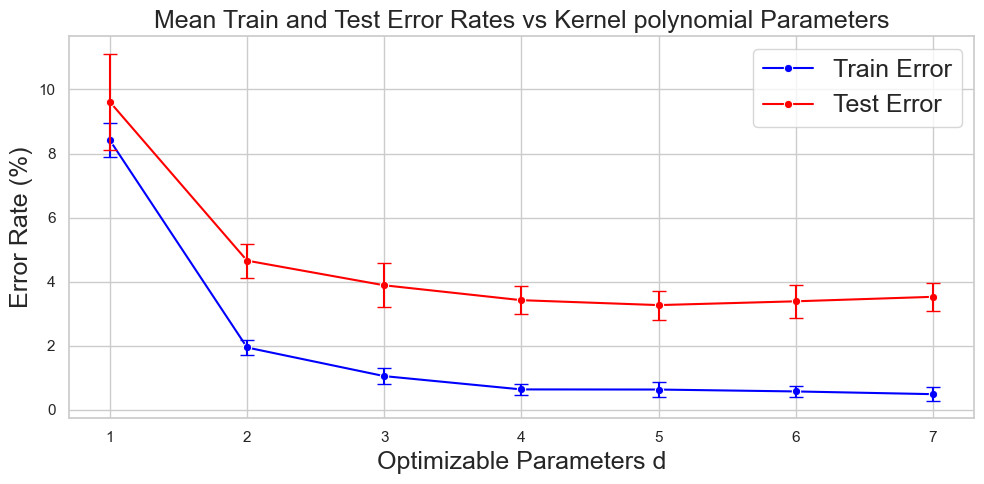

<Figure size 640x480 with 0 Axes>

In [11]:
plot_error_rates(kernel_perceptron_oneVsRest_poly, d_range, 'd', 'polynomial')

## Q2

In [40]:
N_FOLDS = 5

def run_kernel_perceptron_cross_val(x_data, y_labels, N_RUNS, N_FOLDS, params_range, n_classes, kernel_function: callable, Classifier, return_confusion_and_misclassified=False):
    '''
    Runs the kernel perceptron with cross validation
    param x_data: the data
    param y_labels: the labels
    param N_RUNS: number of runs
    param N_FOLDS: number of folds
    param range: the range of d's or c to test
    param n_classes: number of classes
    param kernel_function: the kernel function to use
    return: test_errors, d_stars, confusion_matrices, misclassified_images
    '''
    fold_test_prediction_error = np.zeros(shape=(N_RUNS, N_FOLDS, len(d_range)))
    test_errors = np.zeros(shape=(N_RUNS))
    confusion_matrices = np.zeros(shape=(N_RUNS, n_classes, n_classes))
    misclassified_images = {}
    test_errors = np.zeros(N_RUNS)
    star_params = []
    fold_test_prediction_error = np.zeros((N_RUNS, N_FOLDS, len(params_range)))

    #loop over the runs
    for i_run in range(N_RUNS):
        #split the data into train and test
        X_train, X_test, Y_train, Y_test = train_test_split(
            x_data, y_labels, test_size=0.2, random_state=i_run
        )
        #create the folds
        folds_data: list[FoldData] = create_folds_data(X_train, Y_train, number_of_folds=N_FOLDS)
        #loop over the folds
        for i_fold, fold in enumerate(folds_data):
            #loop over the d's
            for i_j, j in enumerate(params_range):
                #calculate the kernel matrix for the train and test data
                model_train = Classifier(n_classes, kernel_function, j)
                
                #train the kernel perceptron
                model_train.fit(fold.train_data, fold.train_labels, return_training_error=False)
                #calculate the prediction error for each run, fold and d
                fold_test_prediction_error[i_run, i_fold, i_j] = model_train.predict(fold.test_data, fold.test_labels)

        #calculate the d_star/c_star for each run
        star_param, _ = get_d_star_from_cross_validation_error(fold_test_prediction_error[i_run, :, :], ds=params_range)
        star_params.append(star_param)
        model_test = Classifier(n_classes, kernel_function, star_param)
        #train the kernel perceptron with the d_star/c_star
        model_test.fit(X_train, Y_train, return_training_error=False)
        #calculate the test error for each run and d_star/c_star
        test_errors[i_run], y_pred = model_test.predict(X_test, Y_test, return_labels=True)
        if return_confusion_and_misclassified:
            #calculate the confusion matrix for each run and d_star/c_star
            confusion_matrices[i_run, :, :] = calculate_confusion_matrix(Y_test, y_pred)
        
            #record the misclassified images for each run and d_star/c_star
            misclassified_indices = np.where(y_pred!=Y_test)[0]
            misclassified_images[i_run] = {}
            for index in misclassified_indices:
                true_label = Y_test[index]
                misclassified_images[i_run][true_label] = X_test[index]
    if return_confusion_and_misclassified:
        return test_errors, star_params, confusion_matrices, misclassified_images
    return test_errors, star_params

In [41]:
test_errors_poly, d_stars, confusion_matrices, misclassified_images = run_kernel_perceptron_cross_val(x_data, y_labels, N_RUNS, N_FOLDS, d_range, n_classes, kernel_function=polynomial_kernel, Classifier=KernelPerceptron, return_confusion_and_misclassified=True)


In [42]:
print('D stars: ', d_stars)
def calculate_mean_star_param_and_mean_test_error_with_std(test_errors, stars_param, param):
    mean_cross_validation_test_error_with_star_param = np.mean(test_errors, axis=0)
    mean_cross_validation_test_error_std_with_star_param = np.std(test_errors, axis=0)
    mean_cross_validation_star_param = np.mean(stars_param)
    mean_cross_validation_std_star_param = np.std(stars_param)
    print("Mean Test Error {param}: ", mean_cross_validation_test_error_with_star_param, "±", mean_cross_validation_test_error_std_with_star_param)
    print("Mean Best {param}", mean_cross_validation_star_param, "±", mean_cross_validation_std_star_param)

    part_2_results = {
            f"Mean Best {param}": mean_cross_validation_star_param,
            f"Mean Best {param} standard deviation": mean_cross_validation_std_star_param,
            "Mean Test Error": mean_cross_validation_test_error_with_star_param,
            "Test Error Standard Deviation": mean_cross_validation_test_error_std_with_star_param
        }

    df_results_2 = pd.DataFrame.from_dict(part_2_results, orient='index')
    df_results_2.reset_index(inplace=True)
    
    return df_results_2, mean_cross_validation_star_param

df_results_oneVsRest_poly, mean_cross_validation_d_star = calculate_mean_star_param_and_mean_test_error_with_std(test_errors_poly, d_stars, 'd')
df_results_oneVsRest_poly


[5, 6, 5, 5, 6, 5, 5, 4, 6, 4, 7, 6, 4, 5, 5, 7, 6, 5, 7, 6]
[0.03333333 0.02956989 0.02903226 0.03655914 0.0344086  0.03602151
 0.03387097 0.02741935 0.02795699 0.03709677 0.03763441 0.02849462
 0.03870968 0.02849462 0.03010753 0.0311828  0.04569892 0.03602151
 0.03978495 0.03172043]
Mean Test Error {param}:  0.03365591397849462 ± 0.004697460464258662
Mean Best {param} 5.45 ± 0.9205976319760985


,index,0
0,Mean Best d,5.450000
1,Mean Best d standard deviation,0.920598
2,Mean Test Error,0.033656
3,Test Error Standard Deviation,0.004697


## Q3

In [43]:
def plot_confusion_matrix(confusion_matrices):
    std_dev_matrix = calculate_confusion_matrix_std(confusion_matrices)
    mean_confusion_matrix = confusion_matrices.mean(axis=0)
    combined_matrix = np.vectorize(lambda mean, std: f"{mean*100:.2f}% \n± \n{std*100:.2f}%")(mean_confusion_matrix, std_dev_matrix)

    plt.figure(figsize=(12, 10), dpi=80)
    sns.set(style="whitegrid", font_scale=1.1)
    ax = sns.heatmap(mean_confusion_matrix, annot=combined_matrix, fmt="", cmap='coolwarm', cbar=True, square=True, annot_kws={"size": 12}, xticklabels=np.arange(10), yticklabels=np.arange(10))
    plt.title("Error Rate and Standard Deviation", fontsize=19)
    plt.xlabel('Predicted Label', fontsize=19)
    plt.ylabel('True Label', fontsize=19)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()
    plt.savefig('confusion_matrix.png')

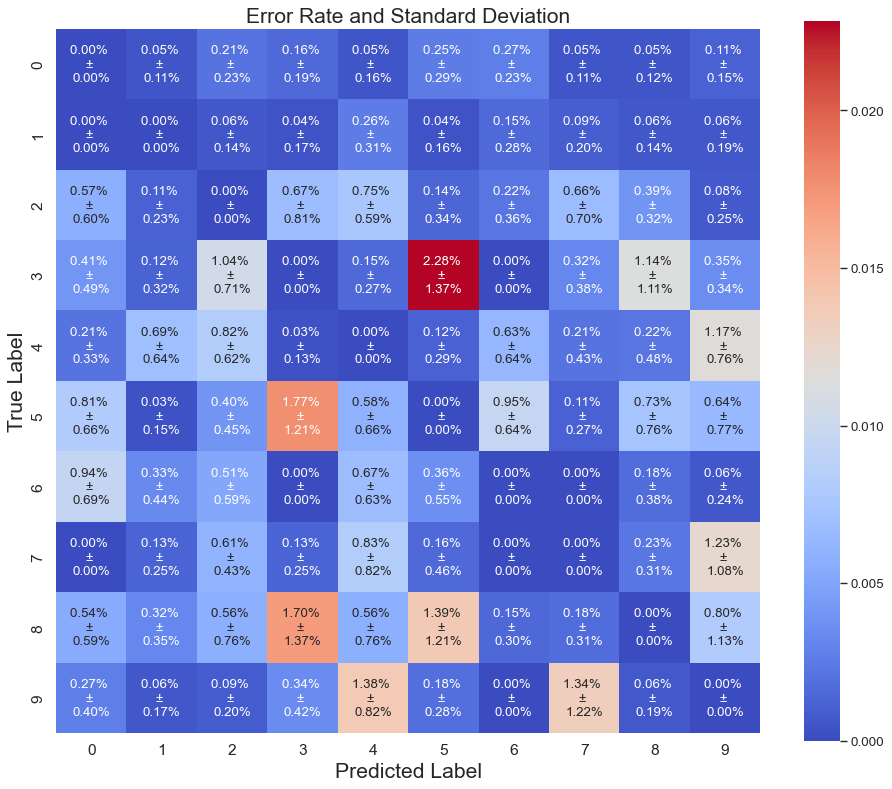

<Figure size 640x480 with 0 Axes>

In [44]:
plot_confusion_matrix(confusion_matrices)

## Q4

Counter({2: 20, 8: 20, 3: 20, 5: 20, 6: 20, 0: 20, 4: 20, 7: 20, 9: 20, 1: 17})


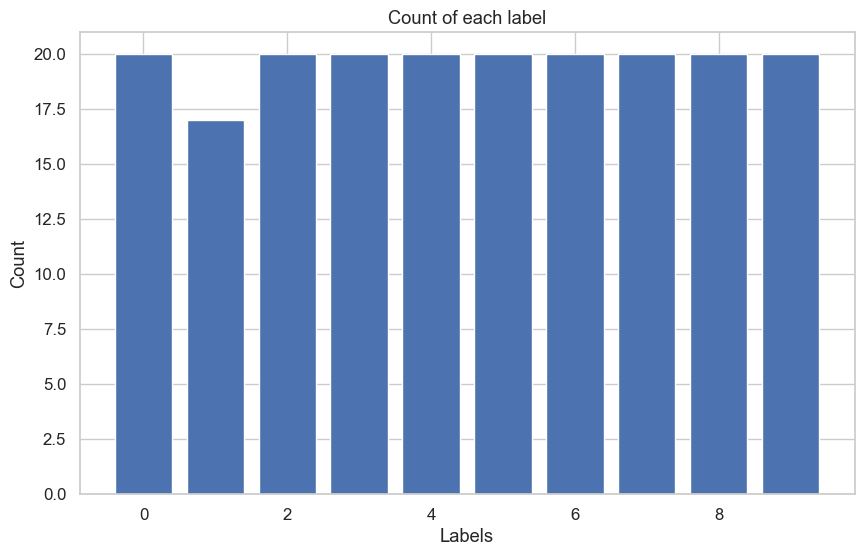

In [53]:
def plot_label_counts(label_counts):
    plt.figure(figsize=(10,6))
    plt.bar(label_counts.keys(), label_counts.values())
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Count of each label')
    plt.show()
    
def get_first_image_by_label(label):
    for image_dict in image_data:
        if image_dict['label'] == label:
            return image_dict['image']

# Initialize counters and data list
label_counts = Counter()
image_counts = Counter()
image_data = []

def count_labels_and_images(misclassified_images, label_counts, image_counts, image_data):
    # Count labels and images
    for i_run, labels in misclassified_images.items():
        for label, image in labels.items():
            image = tuple(image.flatten())
            label_counts[label] += 1
            image_counts[image] += 1

            # Add new image data or update count of existing image data
            for image_dict in image_data:
                if image_dict['image'] == image:
                    image_dict['count'] = image_counts[image]
                    break
            else:
                image_data.append({'image': image, 'count': image_counts[image], 'label': label})
    return label_counts, image_counts, image_data

label_counts, image_counts, image_data = count_labels_and_images(misclassified_images, label_counts, image_counts, image_data)

# Sort image data by count in descending order
image_data.sort(key=lambda x: x['count'], reverse=True)
print(label_counts)

# Get the 5 most common images
most_common_images = image_data[:5]
most_common_labels = label_counts.most_common(5)

############plots for report
plot_label_counts(label_counts)

def plot_common_labels_and_images(most_common_labels, most_common_images, get_first_image_by_label):
    fig, axes = plt.subplots(2, 5, figsize=(25, 10))  # Create a figure with 2 rows of 5 subplots
    fig.suptitle('Most Common Labels and corresponding top misclassified images', fontsize=20)
    
    for ax, (label, count) in zip(axes[1], most_common_labels):  # Use the second row of subplots
        image1 = np.array(get_first_image_by_label(label)).reshape(16, 16)
        ax.imshow(image1, cmap='gray')
        ax.axis('off')
        ax.set_title(f" Digit {label} occurs {count} times", fontsize=16)
    
        # Display each of the 5 most common images in its own subplot
    for ax, data in zip(axes[0], most_common_images):  # Use the first row of subplots
        image, count2, label = data['image'], data['count'], data['label']
        image = np.array(image).reshape(16, 16)
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(f"This image with digit {label} occurs {count2} times", fontsize=16)


        


    plt.show()



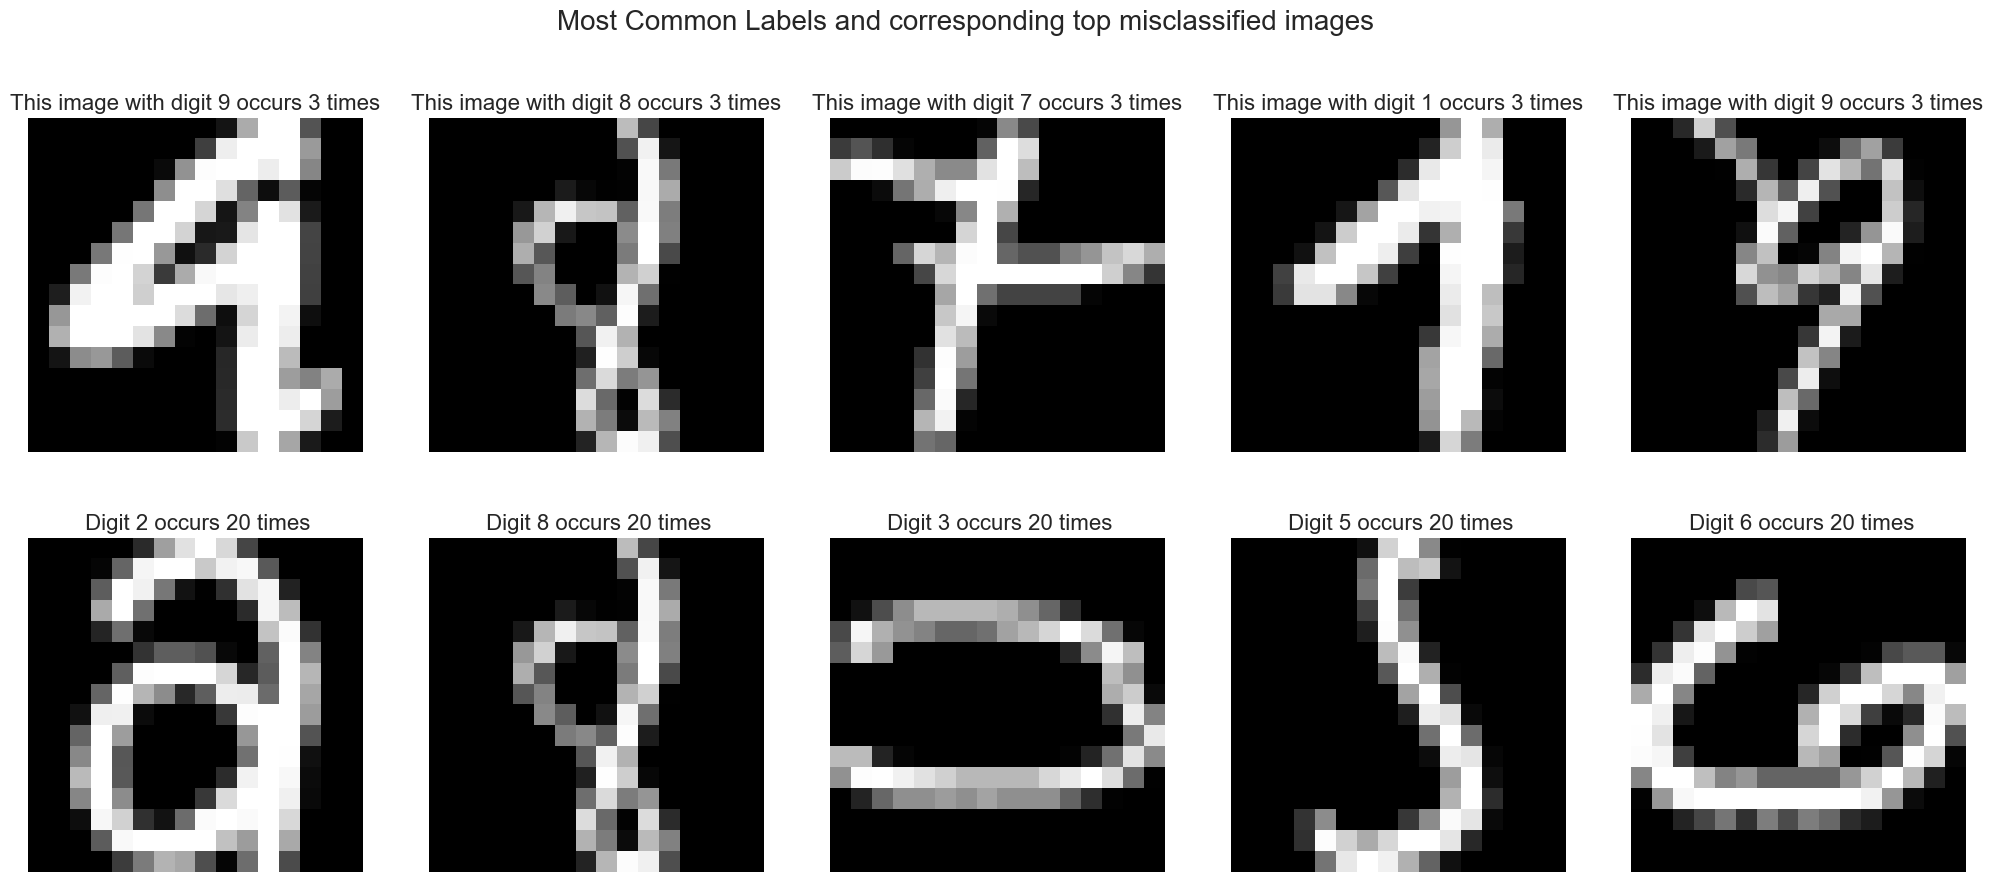

In [54]:
plot_common_labels_and_images(most_common_labels, most_common_images, get_first_image_by_label)

## Q5

In [55]:
c_range = [0.001, 0.01, 0.1, 1, 10]
mean_train_errors_gauss, mean_test_errors_gauss, mean_std_train_errors_gauss, mean_std_test_errors_gauss = run_experiment_without_cross_val(x_data, y_labels, N_RUNS, c_range, n_classes, kernel_function=gaussian_kernel_matrix, Classifier=KernelPerceptron)

In [56]:
gauss_kernel_perceptron = create_summary_table(mean_train_errors_gauss, mean_std_train_errors_gauss, mean_test_errors_gauss, mean_std_test_errors_gauss, c_range, parameter_name='sigma ')
gauss_kernel_perceptron

,Mean Train Error,Std Train Error,Mean Test Error,Std Test Error
parameter,,,,
sigma0.001,0.07768,0.00525,0.08414,0.01822
sigma0.01,0.00772,0.00278,0.03543,0.00420
sigma0.1,0.00060,0.00042,0.04825,0.00528
sigma1.0,0.00022,0.00031,0.06185,0.00426
sigma10.0,0.00042,0.00035,0.19581,0.00715


c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

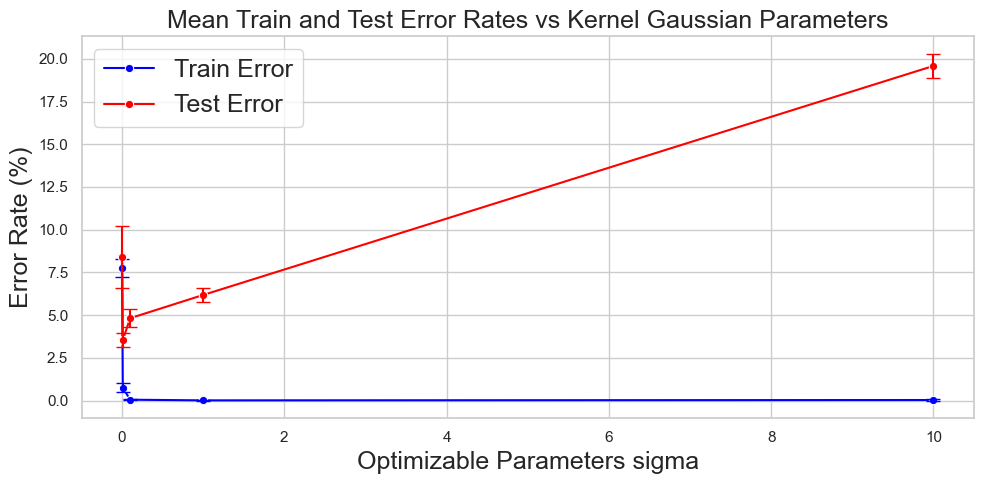

<Figure size 640x480 with 0 Axes>

In [57]:
plot_error_rates(gauss_kernel_perceptron, c_range, 'sigma', 'Gaussian')

In [21]:
new_c_range = [0.001, 0.01, 0.03, 0.1, 0.3, 1]
test_errors_gauss, c_stars = run_kernel_perceptron_cross_val(x_data, y_labels, N_RUNS, N_FOLDS, new_c_range, n_classes, kernel_function=gaussian_kernel_matrix, Classifier=KernelPerceptron, return_confusion_and_misclassified=False)

In [36]:
print(c_stars)

[0.03, 0.01, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.01, 0.03, 0.01, 0.03, 0.03, 0.03, 0.03, 0.03, 0.01, 0.03]


In [22]:
df_c_star_results, mean_cross_validation_c_star = calculate_mean_star_param_and_mean_test_error_with_std(test_errors_gauss, c_stars, 'c')
df_c_star_results

Mean Test Error {param}:  0.03255376344086021 ± 0.0034986535903560943
Mean Best {param} 0.026000000000000006 ± 0.008


,index,0
0,Mean Best c,0.026000
1,Mean Best c standard deviation,0.008000
2,Mean Test Error,0.032554
3,Test Error Standard Deviation,0.003499


## Q6

DO 20 runs without cross validation to see training and test erros for a different range of parameters. Do cross validation to estimate gamma *. The chosen new algorithm is One Vs One kernel perceptron.

In [23]:
def calculate_accuracy(actual, predicted):
    return np.mean(actual == predicted)


def softmax(x):
    # Subtracting the max can help with numerical stability
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)


def make_probabilistic_predictions(kappas):
    """
    How does this function work?
    - We'll take in our kappas (confidence vectors)
    - We'll convert them to probabilities using softmax
    - Then we can sample from the probabilities
    """
    predictions = []
    for kappa in kappas:
        # Convert kappa to probabilities using softmax
        kappa = np.expand_dims(kappa, axis=0)  # Ensure kappa is a 2D array
        probabilities = softmax(kappa)
        
        # Now we can sample from the probabilities
        predictions.append(np.random.choice(len(probabilities[0]), p=probabilities[0]))
    return np.array(predictions)

In [24]:
from joblib import Parallel, delayed

class BinaryKernelPerceptron:
    # Lets make a binary classifier that can distinguish between two classes
    """
    Binary Kernel Perceptron
    We'll need to make a fitting function and a prediction function.
    The fitting function will take in our training data and train our model.
    The prediction function will take in our test data and return our predictions.

    alpha: The weights of our model
    train_data: The data we trained on
    kernel_matrix: The kernel matrix of our training data
    kernel_function: The kernel function we're using - Guassian for now
    kernel_param: The parameter for our kernel function - gamma for now
    """


    def __init__(self, kernel_function, kernel_param):
        self.kernel_function = kernel_function
        self.kernel_param = kernel_param
        self.alpha = None
        self.train_data = None

    def fit(self, X, y, tolerance=0.01, max_epochs=10):
        '''
        Fits the model to the data
        :param X: the data
        :param y: the labels
        :param tolerance: the tolerance
        :param max_epochs: the maximum number of epochs
        :return: None
        '''
        self.alpha = np.zeros(X.shape[0])
        self.train_data = X
        # It makes it a bit more efficient to precompute the kernel matrix
        self.kernel_matrix = self.kernel_function(X, X, self.kernel_param)

        for epoch in range(max_epochs):
            # Now for the core logic of the perceptron algorithm
            predictions = np.sign(np.dot(self.kernel_matrix, self.alpha))
            # We'll update our weights based on the errors we made
            errors = (y * predictions <= 0) # Where did we make errors?
            self.alpha[errors] += y[errors] # Go to those classes and update our weights
            # As a sort of early stopping
            if np.sum(errors) / X.shape[0] < tolerance:
                break

    def predict(self, X):
        # We need to compute the kernel matrix between our test data and our training data
        kernel_values = self.kernel_function(X, self.train_data, self.kernel_param)
        # And then do the dot product between our weights and the kernel matrix
        return np.sign(np.dot(kernel_values, self.alpha))

class OneVsOneKernelPerceptron:
    """
    This class will take in a number of classes and train a binary classifier for each pair of classes.
    So for a large number of classes, it wont be quite as effient as our previous One-vs-Rest classifier.
    So how will we build it?
    - We'll need to train a binary classifier for each pair of classes
    - We'll need to predict using each classifier
    - Then find the class with the most votes
    - If we normalise those votes it would make kappa (a confidence vector)
    - Then to get a final prediction we could either take the class with the highest kappa value or sample from the distribution
    """
    def __init__(self, n_classes, kernel_function, kernel_param):
        self.n_classes = n_classes
        self.kernel_function = kernel_function
        self.kernel_param = kernel_param
        self.classifiers = {} # We will end up with k(k-1)/2 classifiers where k=10. So 45
    
    @staticmethod
    def fit_binary_classifier(class1, class2, X, y, kernel_function, kernel_param, **fit_params):
        idx = np.where((y == class1) | (y == class2))[0]
        X_pair, y_pair = X[idx], y[idx]
        # We'll need to convert our labels to -1 and 1
        y_pair = np.where(y_pair == class1, 1, -1)
        # We'll use our BinaryKernelPerceptron class to train our binary classifiers
        classifier = BinaryKernelPerceptron(kernel_function, kernel_param)
        classifier.fit(X_pair, y_pair, **fit_params)
        return (class1, class2), classifier

    def fit(self, X, y, return_training_error=True, **fit_params):
        X = X.astype(np.float32)
        # We'll use joblib to parallelise the fitting of our binary classifiers
        results = Parallel(n_jobs=-1)(delayed(self.fit_binary_classifier)(class1, class2, X, y, self.kernel_function, self.kernel_param, **fit_params) for class1, class2 in combinations(range(self.n_classes), 2))
        # We'll store our classifiers in a dictionary
        self.classifiers = dict(results)
        if return_training_error:
            return self.predict(X, y)


    def predict(self, X, y,return_labels=False, return_confidences=False):
        X = X.astype(np.float32)
        # The votes will be a matrix of shape (num_samples, num_classes)
        # So each row will be the number of votes for each class, so to get the final prediction we could just take the argmax
        votes = np.zeros((X.shape[0], self.n_classes))
        confidences = np.zeros((X.shape[0], self.n_classes))

        for (class1, class2), classifier in self.classifiers.items():
            predictions = classifier.predict(X)
            # To update the votes we need to add 1 to the class we predicted and -1 to the class we didn't predict
            votes[:, class1] += (predictions == 1)
            votes[:, class2] += (predictions == -1)
            confidences[:, class1] += (predictions == 1) * np.sum(classifier.alpha[classifier.alpha > 0])
            confidences[:, class2] += (predictions == -1) * np.sum(classifier.alpha[classifier.alpha > 0])
        
        y_pred = np.argmax(votes, axis=1)
        error_rate = np.mean(y != y_pred)

        if return_confidences:
            return error_rate, y_pred, confidences
        if return_labels:
            return error_rate, y_pred
        else:
            return error_rate



## Repeating Q1 20 runs with gamma range 0.05, 0.25, 0.5, 0.8, 1.2

In [25]:
gamma_values = [0.05, 0.25, 0.5, 0.8, 1.2]
mean_train_errors_1vs1, mean_test_errors_1vs1, mean_std_train_errors_1vs1, mean_std_test_errors_1vs1 = run_experiment_without_cross_val(x_data, y_labels, N_RUNS, gamma_values, n_classes, kernel_function=gaussian_kernel_matrix, Classifier=OneVsOneKernelPerceptron)

In [26]:
basic_results_oneVsOne = create_summary_table(mean_train_errors_1vs1, mean_std_train_errors_1vs1, mean_test_errors_1vs1, mean_std_test_errors_1vs1, gamma_values, parameter_name='Gamma ')

basic_results_oneVsOne

,Mean Train Error,Std Train Error,Mean Test Error,Std Test Error
parameter,,,,
Gamma 0.05,0.01149,0.00055,0.08508,0.00553
Gamma 0.25,0.00024,0.00006,0.03269,0.00467
Gamma 0.5,0.00012,0.00004,0.03212,0.00432
Gamma 0.8,0.00012,0.00004,0.03503,0.00393
Gamma 1.2,0.00000,0.00000,0.08492,0.00630


c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

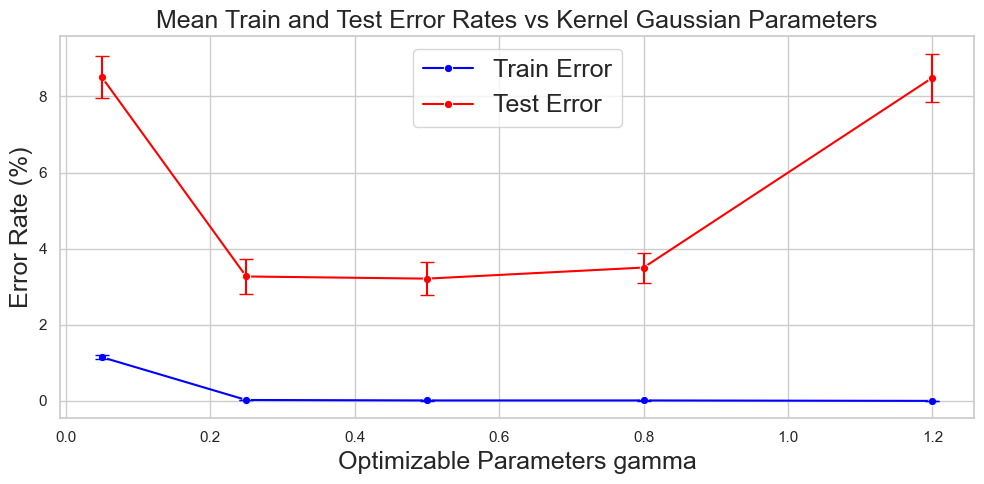

<Figure size 640x480 with 0 Axes>

In [27]:
plot_error_rates(basic_results_oneVsOne, gamma_values, 'gamma', 'Gaussian')

## Repeating Q2 cross validation

In [29]:
gamma_values = [0.05, 0.25, 0.4, 0.6, 0.8, 1.2]
test_errors_1vs1, gamma_stars = run_kernel_perceptron_cross_val(x_data, y_labels, N_RUNS, N_FOLDS, gamma_values, n_classes, kernel_function=gaussian_kernel_matrix, Classifier=OneVsOneKernelPerceptron, return_confusion_and_misclassified=False)
print(gamma_stars)

[0.6, 0.4, 0.6, 0.4, 0.4, 0.4, 0.25, 0.6, 0.4, 0.6, 0.4, 0.6, 0.4, 0.4, 0.4, 0.6, 0.6, 0.4, 0.4, 0.4]
[0.0311828  0.03225806 0.0327957  0.0311828  0.02849462 0.03333333
 0.03709677 0.0344086  0.02688172 0.03225806 0.03924731 0.03010753
 0.03602151 0.02526882 0.02634409 0.02473118 0.03548387 0.03494624
 0.03978495 0.03225806]


In [30]:
df_results_oneVSone, mean_cross_validation_gamma_star = calculate_mean_star_param_and_mean_test_error_with_std(test_errors_1vs1, gamma_stars, 'gamma')
df_results_oneVSone

Mean Test Error {param}:  0.03220430107526882 ± 0.004226162123531147
Mean Best {param} 0.4625000000000001 ± 0.10591860082157427


,index,0
0,Mean Best gamma,0.462500
1,Mean Best gamma standard deviation,0.105919
2,Mean Test Error,0.032204
3,Test Error Standard Deviation,0.004226
